# #04 - TEDA Forecasting x LSTM x kNN

## 1. Modules import

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from random import randint, sample

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, recall_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [7]:
from sklearn import neighbors

In [8]:
import tensorflow as tf

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

tf.keras.utils.set_random_seed(1)

tf.config.experimental.enable_op_determinism()

#### Importing our modules:

In [10]:
from teda import TEDA
from RLSFilter import RLSFilter

from treating import dataTreating, dataSpliting, dataProcessing, dataSplit

In [11]:
def find_indices(list_to_check, item_to_find):
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

## 2. Data managing

### 2.1 Power data:

In [12]:
data = pd.read_csv("Electric_Production.csv")
data.rename(columns={'DATE':'Date', 'IPG2211A2N':'Production'}, inplace=True)
data.head()

,Date,Production
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [13]:
series = "Production"
date = "Date"

### 2.2 Inserting outliers:

In [14]:
data['label'] = 0

In [15]:
outliers_percentage = 8/100

#Outliers do tipo zero
#z = o[0:np.round(len(o)/2).astype(int)]
z = [61,37,287,230,214,162,98,30,278,28,25,314,348,195,113,387]

#Outliers do tipo pico
#p = o[np.round(len(o)/2).astype(int): -1]
p = [125,242,291,377,34,206,249,118,389,12,376,375,74,146,272,368]

#### Peak-type outliers will have **twice** the magnitude. Therefore:

In [16]:
data['Outlier'] = data[series]

data['Outlier'].iloc[p] = 1.5*data[series].iloc[p]
data['label'].iloc[p] = 1

c:\Users\Samsung\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


#### Zero-type outliers has value equals **zero**:

In [17]:
data['Outlier'].iloc[z] = 0
data['label'].iloc[z] = 1

### Let's see the new curve:

In [18]:
figure = make_subplots(specs=[[{"secondary_y": True}]])

figure.update_layout(
    title="Dataset"
)

figure.add_trace(
    go.Scatter(y=data['Production'], name='Electric without Outliers'),
    secondary_y=False
)

figure.update_xaxes(title='Time (months)')
figure.update_yaxes(title='Eletric Production', secondary_y=False)
figure.show()

In [19]:
figure = make_subplots(specs=[[{"secondary_y": True}]])

figure.update_layout(
    title="Dataset with outliers"
)

figure.add_trace(
    go.Scatter(y=data['Outlier'], name='With Outliers'),
    secondary_y=False
)

figure.update_xaxes(title='Time (months)')
figure.update_yaxes(title='Eletric Production', secondary_y=False)
figure.show()

# 3.1 TEDA Forecasting

## 3.1.1 Defining TEDA Forecasting variables

In [20]:
RMSE_full_tf = []
MAE_full_tf = []

#Outliers detection
threshold_tf = 1.2
N_outlier_max_tf  = 1
flagCorrection = True

#Forecasting
forgetting = 0.95
regularization = 0.1
window_tf = 4      # Filter_order equivalent to window size
forecasting = 4

## 3.1.2 TEDA Forecasting Running

In [21]:
# Data processing
df, df_train, df_test, X_train, y_train, X_test, y_test = dataSplit(data["Outlier"], data["label"], window=window_tf, forecasting=forecasting, N_splits=4)

# Labels Index
labelsIndex = find_indices(df_test['label'], 1)
ts = np.linspace(0, len(df_test), len(df_test))

#TEDA
teda = TEDA(threshold=threshold_tf)
N_outlier_max = N_outlier_max_tf    # Consecutive outlier correction flagN_outlier_max   # Maximum of outliers corrected by TEDAForecasting
correction = flagCorrection    # Consecutive outlier correction flag

FLAG = []

#RLS
w0 = np.zeros(window_tf).tolist()            # Initial weights
X_ant = np.zeros(window_tf).tolist()         # Initial previous input
rls_filter = RLSFilter(n = window_tf, mu = forgetting, delta=regularization, w=w0) #Defining the filter instance

Ya_py = []          # Vector of auxiliary predicted values
Y_py = []           # Vector of predicted values
Y_v = []            # Vector of virtual predicted values
DB = []             # Vector of saved values (database)
outlier_count = 0   # Outlier count 
y_pred_py = 0.0     # Initial predicted value     

for i in df_test['x(t)']:
    ## Acquiring the data input
    valor_atual = i

    #Checking if it is an outlier
    flag = teda.run(valor_atual)
    FLAG.append(flag)

    ## First Stage: Correcting outlier
    if (flag == 1):       
        outlier_count = outlier_count + 1
        valor_atual = y_pred_py
    else:
        outlier_count = 0
    
    #Evaluating the flood of outliers
    if(correction == True and outlier_count == N_outlier_max + 1):
        valor_atual = i
    
    #Saving 
    Ya_py.append(y_pred_py)

    # Updating weights
    rls_filter.update(valor_atual, np.array(X_ant))

    input_vector = []
    for j in X_ant[1:]:
        input_vector.append(j)
    input_vector.append(valor_atual)

    #Predicting the next value
    y_pred_py = rls_filter.filter(input_vector)
    Y_py.append(y_pred_py)

    # Creating virtual inputs
    virtual_input = input_vector[1:]
    virtual_input.append(y_pred_py)

    # Creating virtual filter
    w_virtual = []
    for x in rls_filter.w:
        w_virtual.append(x)
    virtual_filter = RLSFilter(n = window_tf, mu = forgetting, delta=regularization, w=w_virtual) #Defining the filter instance
    virtual_filter.update(y_pred_py, np.array(input_vector))


    for l in range(1, forecasting):
        #Predicting the next value
        y_pred_virtual = virtual_filter.filter(virtual_input)
        virtual_filter.update(y_pred_virtual, np.array(virtual_input))
        Y_v.append(y_pred_virtual)

        virtual_input = virtual_input[1:]
        virtual_input.append(y_pred_virtual)
    
    # Second stage
    if (flag == 1):
        valor_atual = y_pred_py

    if(correction == True and outlier_count == N_outlier_max + 1):
        outlier_count = 0
        valor_atual = i
    DB.append(valor_atual)

    #Updating previous values vector
    X_ant = input_vector

df_test['flag_py'] = FLAG
df_test['save_py'] = DB
df_test['ya_pred_py'] = Ya_py
df_test['y_pred_py'] = Y_py

### Creating the forecasting dataframe:
Y_v = np.array(Y_v).reshape(len(df_test),(forecasting-1))

df_y_forecasting_columns = []
for i in range(1, forecasting+1):
    df_y_forecasting_columns.append('y(t+' + str(i) + ')')

df_Y_v = pd.DataFrame(data=Y_v)
df_Y_v.insert(loc=0, column=df_y_forecasting_columns[0], value=Y_py, allow_duplicates=True)
df_Y_v.set_axis(df_y_forecasting_columns, axis=1, inplace=True)

numberOfOutliersPython = df_test['flag_py'].sum()
outliersIndexPython = find_indices(df_test['flag_py'], 1)

# TEDA Metrics:
f1 = f1_score(df_test['label'], df_test['flag_py'])
accuracy = accuracy_score(df_test['label'], df_test['flag_py'])
recall = recall_score(df_test['label'], df_test['flag_py'])

# Forecasting
RMSE_tf = []
for i in range(0, forecasting):
    rmse_tf = mean_squared_error(y_test[0:-1, i], df_Y_v.iloc[1:, i].values, squared=False)
    RMSE_tf.append(rmse_tf)
rmse_pred_tf = mean_squared_error(y_test[0:-1, 0], df_Y_v.iloc[1:, 0].values, squared=False)
RMSE_full_tf.append(RMSE_tf)
RMSE_mean_tf = np.mean(RMSE_tf)
RMSE_max_tf = np.max(RMSE_tf)
RMSE_min_tf = np.min(RMSE_tf)
RMSE_std_tf = np.std(RMSE_tf)

MAE_tf = []
for i in range(0, forecasting):
    mae_tf = mean_absolute_error(y_test[0:-1, i], df_Y_v.iloc[1:, i].values)
    MAE_tf.append(mae_tf)
mae_pred_tf = mean_absolute_error(y_test[0:-1, 0], df_Y_v.iloc[1:, 0].values)
MAE_full_tf.append(MAE_tf)
MAE_mean_tf = np.mean(MAE_tf)
MAE_max_tf = np.max(MAE_tf)
MAE_min_tf = np.min(MAE_tf)
MAE_std_tf = np.std(MAE_tf)


# 3.2 LSTM

## 3.2.1 Defining LSTM variables:

In [22]:
RMSE_full_lstm = []
MAE_full_lstm = []

#Outliers detection
threshold_lstm = 2.5
N_outlier_max_lstm = 2
flagCorrection_lstm = True

#LSTM
window_lstm = 3
forecasting_lstm = 4
n_features = 1
n_Units = 10
n_Epochs = 100
actList = 'relu'
optList = 'adam'

## 3.2.1 LSTM Running

In [23]:
RMSE_full_lstm = []
MAE_full_lstm = []

# Data processing
df, df_train, df_test, X_train, y_train, X_test, y_test = dataSplit(data["Outlier"], data["label"], window=window_lstm, forecasting=forecasting_lstm, N_splits=4)

# Labels Index
labelsIndex = find_indices(df_test['label'], 1)
ts = np.linspace(0, len(df_test), len(df_test))

#TEDA
teda = TEDA(threshold=threshold_lstm)
N_outlier_max = N_outlier_max_lstm    # Consecutive outlier correction flagN_outlier_max   # Maximum of outliers corrected by TEDAForecasting
correction = flagCorrection_lstm    # Consecutive outlier correction flag

FLAG = []

#LSTM
# define model
model = Sequential()
model.add(LSTM(n_Units, activation='relu', return_sequences=True, input_shape=(window_lstm, n_features)))
model.add(LSTM(n_Units, activation='relu'))
model.add(Dense(forecasting_lstm))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X_train, y_train, epochs=n_Epochs, verbose=0)

Y_LSTM = []
Ya_py = []          # Vector of auxiliary predicted values
Y_py = []           # Vector of predicted values
Y_v = []            # Vector of virtual predicted values
DB = []             # Vector of saved values (database)
outlier_count = 0   # Outlier count 
y_lstm_pred_py = 0.0     # Initial predicted value
X_ant = np.zeros(window_lstm).tolist()         # Initial previous input


for i in X_test:
    ## Acquiring the data input

    valor_atual = []
    for j in X_ant[1:]:
        valor_atual.append(j)
    valor_atual.append(i[-1])

    #Checking if it is an outlier
    flag = teda.run(valor_atual[-1])
    FLAG.append(flag)

    ## First Stage: Correcting outlier
    if (flag == 1):      
        outlier_count = outlier_count + 1
        valor_atual[-1] = y_lstm_pred_py[0]
    else:
        outlier_count = 0
    
    #Evaluating the flood of outliers
    if(correction == True and outlier_count == N_outlier_max + 1):
        valor_atual[-1] = i[0]
    
    #Saving 
    Ya_py.append(y_lstm_pred_py)

    input_vector_reshaped = np.array(valor_atual).reshape((1, window_lstm, n_features))
    #Predicting the next value
    y_lstm_pred = model.predict(input_vector_reshaped, verbose=0)
    y_lstm_pred_py = y_lstm_pred.tolist()[0]

    Y_LSTM.append(y_lstm_pred_py)

    
    # Second stage
    if (flag == 1):
        valor_atual[-1] = y_lstm_pred_py[0]

    if(correction == True and outlier_count == N_outlier_max + 1):
        outlier_count = 0
        valor_atual[-1] = i[0]
        
    DB.append(valor_atual)

    #Updating previous values vector
    X_ant = valor_atual


df_test['flag_py'] = FLAG
df_test['save_py'] = DB
df_test['ya_pred_py'] = Ya_py
df_test['y_lstm_pred_py'] = Y_LSTM

numberOfOutliersPython = df_test['flag_py'].sum()
outliersIndexPython = find_indices(df_test['flag_py'], 1)

# TEDA Metrics:
f1 = f1_score(df_test['label'], df_test['flag_py'])
accuracy = accuracy_score(df_test['label'], df_test['flag_py'])
recall = recall_score(df_test['label'], df_test['flag_py'])


# Forecasting
RMSE_LSTM = []
for i in range(0, forecasting_lstm):
    rmse_lstm = mean_squared_error(y_test[0:-1, i], np.array(Y_LSTM)[1:, i], squared=False)
    RMSE_LSTM.append(rmse_lstm)
rmse_pred_lstm = mean_squared_error(y_test[0:-1, 0], np.array(Y_LSTM)[1:, 0], squared=False)
RMSE_full_lstm.append(RMSE_LSTM)
RMSE_mean_lstm = np.mean(RMSE_LSTM)
RMSE_max_lstm = np.max(RMSE_LSTM)
RMSE_min_lstm = np.min(RMSE_LSTM)
RMSE_std_lstm = np.std(RMSE_LSTM)

MAE_LSTM = []
for i in range(0, forecasting_lstm):
    mae_lstm = mean_absolute_error(y_test[0:-1, i], np.array(Y_LSTM)[1:, i])
    MAE_LSTM.append(mae_lstm)
mae_pred_lstm = mean_absolute_error(y_test[0:-1, 0], np.array(Y_LSTM)[1:, 0])
MAE_full_lstm.append(MAE_LSTM)
MAE_mean_lstm = np.mean(MAE_LSTM)
MAE_max_lstm = np.max(MAE_LSTM)
MAE_min_lstm = np.min(MAE_LSTM)
MAE_std_lstm = np.std(MAE_LSTM)

# 3.3 kNN

## 3.3.1 Defining kNN variables

In [24]:
threshold_knn = 1.2

window_knn = 4
forecasting_knn = 4
n_neighbors = 10
weights_method = 'uniform'
N_outlier_max_knn = 2           # Consecutive outlier correction flagN_outlier_max   # Maximum of outliers corrected by TEDAForecasting
flagCorrection_knn = True    # Consecutive outlier correction flag

## 3.3.2 TEDA+kNN Running

In [25]:
RMSE_full_knn = []
MAE_full_knn = []

# Data processing
df, df_train, df_test, X_train, y_train, X_test, y_test = dataSplit(data["Outlier"], data["label"], window=window_knn, forecasting=forecasting_knn, N_splits=4)

#TEDA
teda = TEDA(threshold=threshold_knn)
N_outlier_max = N_outlier_max_knn    # Consecutive outlier correction flagN_outlier_max   # Maximum of outliers corrected by TEDAForecasting
correction = flagCorrection_knn    # Consecutive outlier correction flag

FLAG = []

# kNN Model
knn_model = neighbors.KNeighborsRegressor(n_neighbors, weights=weights_method)

#fitting
knn_model.fit(X_train, y_train)


Y_KNN = []
Ya_py = []          # Vector of auxiliary predicted values
Y_py = []           # Vector of predicted values
Y_v = []            # Vector of virtual predicted values
DB = []             # Vector of saved values (database)
outlier_count = 0   # Outlier count 
y_knn_pred_py = 0.0     # Initial predicted value
X_ant = np.zeros(window_knn).tolist()         # Initial previous input


for i in X_test:
    ## Acquiring the data input

    valor_atual = []
    for j in X_ant[1:]:
        valor_atual.append(j)
    valor_atual.append(i[-1])

    #Checking if it is an outlier
    flag = teda.run(valor_atual[-1])
    FLAG.append(flag)

    ## First Stage: Correcting outlier
    if (flag == 1):      
        outlier_count = outlier_count + 1
        valor_atual[-1] = y_knn_pred_py[0]
    else:
        outlier_count = 0
    
    #Evaluating the flood of outliers
    if(correction == True and outlier_count == N_outlier_max + 1):
        valor_atual[-1] = i[0]
    
    #Saving 
    Ya_py.append(y_knn_pred_py)

    input_vector_reshaped = np.array(valor_atual).reshape(1,-1)
    #Predicting the next value
    y_knn = knn_model.predict(input_vector_reshaped)
    y_knn_pred_py = y_knn[0]

    Y_KNN.append(y_knn_pred_py)

    
    # Second stage
    if (flag == 1):
        valor_atual[-1] = y_knn_pred_py[0]

    if(correction == True and outlier_count == N_outlier_max + 1):
        outlier_count = 0
        valor_atual[-1] = i[0]
        
    DB.append(valor_atual)

    #Updating previous values vector
    X_ant = valor_atual


df_test['flag_py'] = FLAG
df_test['save_py'] = DB
df_test['ya_pred_py'] = Ya_py
df_test['y_knn_pred_py'] = Y_KNN

numberOfOutliersPython = df_test['flag_py'].sum()
outliersIndexPython = find_indices(df_test['flag_py'], 1)

# TEDA Metrics:
f1 = f1_score(df_test['label'], df_test['flag_py'])
accuracy = accuracy_score(df_test['label'], df_test['flag_py'])
recall = recall_score(df_test['label'], df_test['flag_py'])


# Forecasting
RMSE_KNN = []
for i in range(0, forecasting_knn):
    rmse_knn = mean_squared_error(y_test[0:-1, i], np.array(Y_KNN)[1:, i], squared=False)
    RMSE_KNN.append(rmse_knn)
rmse_pred_knn = mean_squared_error(y_test[0:-1, 0], np.array(Y_KNN)[1:, 0], squared=False)
RMSE_full_knn.append(RMSE_KNN)
RMSE_mean_knn = np.mean(RMSE_KNN)
RMSE_max_knn = np.max(RMSE_KNN)
RMSE_min_knn = np.min(RMSE_KNN)
RMSE_std_knn = np.std(RMSE_KNN)

MAE_KNN = []
for i in range(0, forecasting_knn):
    mae_knn = mean_absolute_error(y_test[0:-1, i], np.array(Y_KNN)[1:, i])
    MAE_KNN.append(mae_knn)
mae_pred = mean_absolute_error(y_test[0:-1, 0], np.array(Y_KNN)[1:, 0])
MAE_full_knn.append(MAE_KNN)
MAE_mean = np.mean(MAE_KNN)
MAE_max = np.max(MAE_KNN)
MAE_min = np.min(MAE_KNN)
MAE_std = np.std(MAE_KNN)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


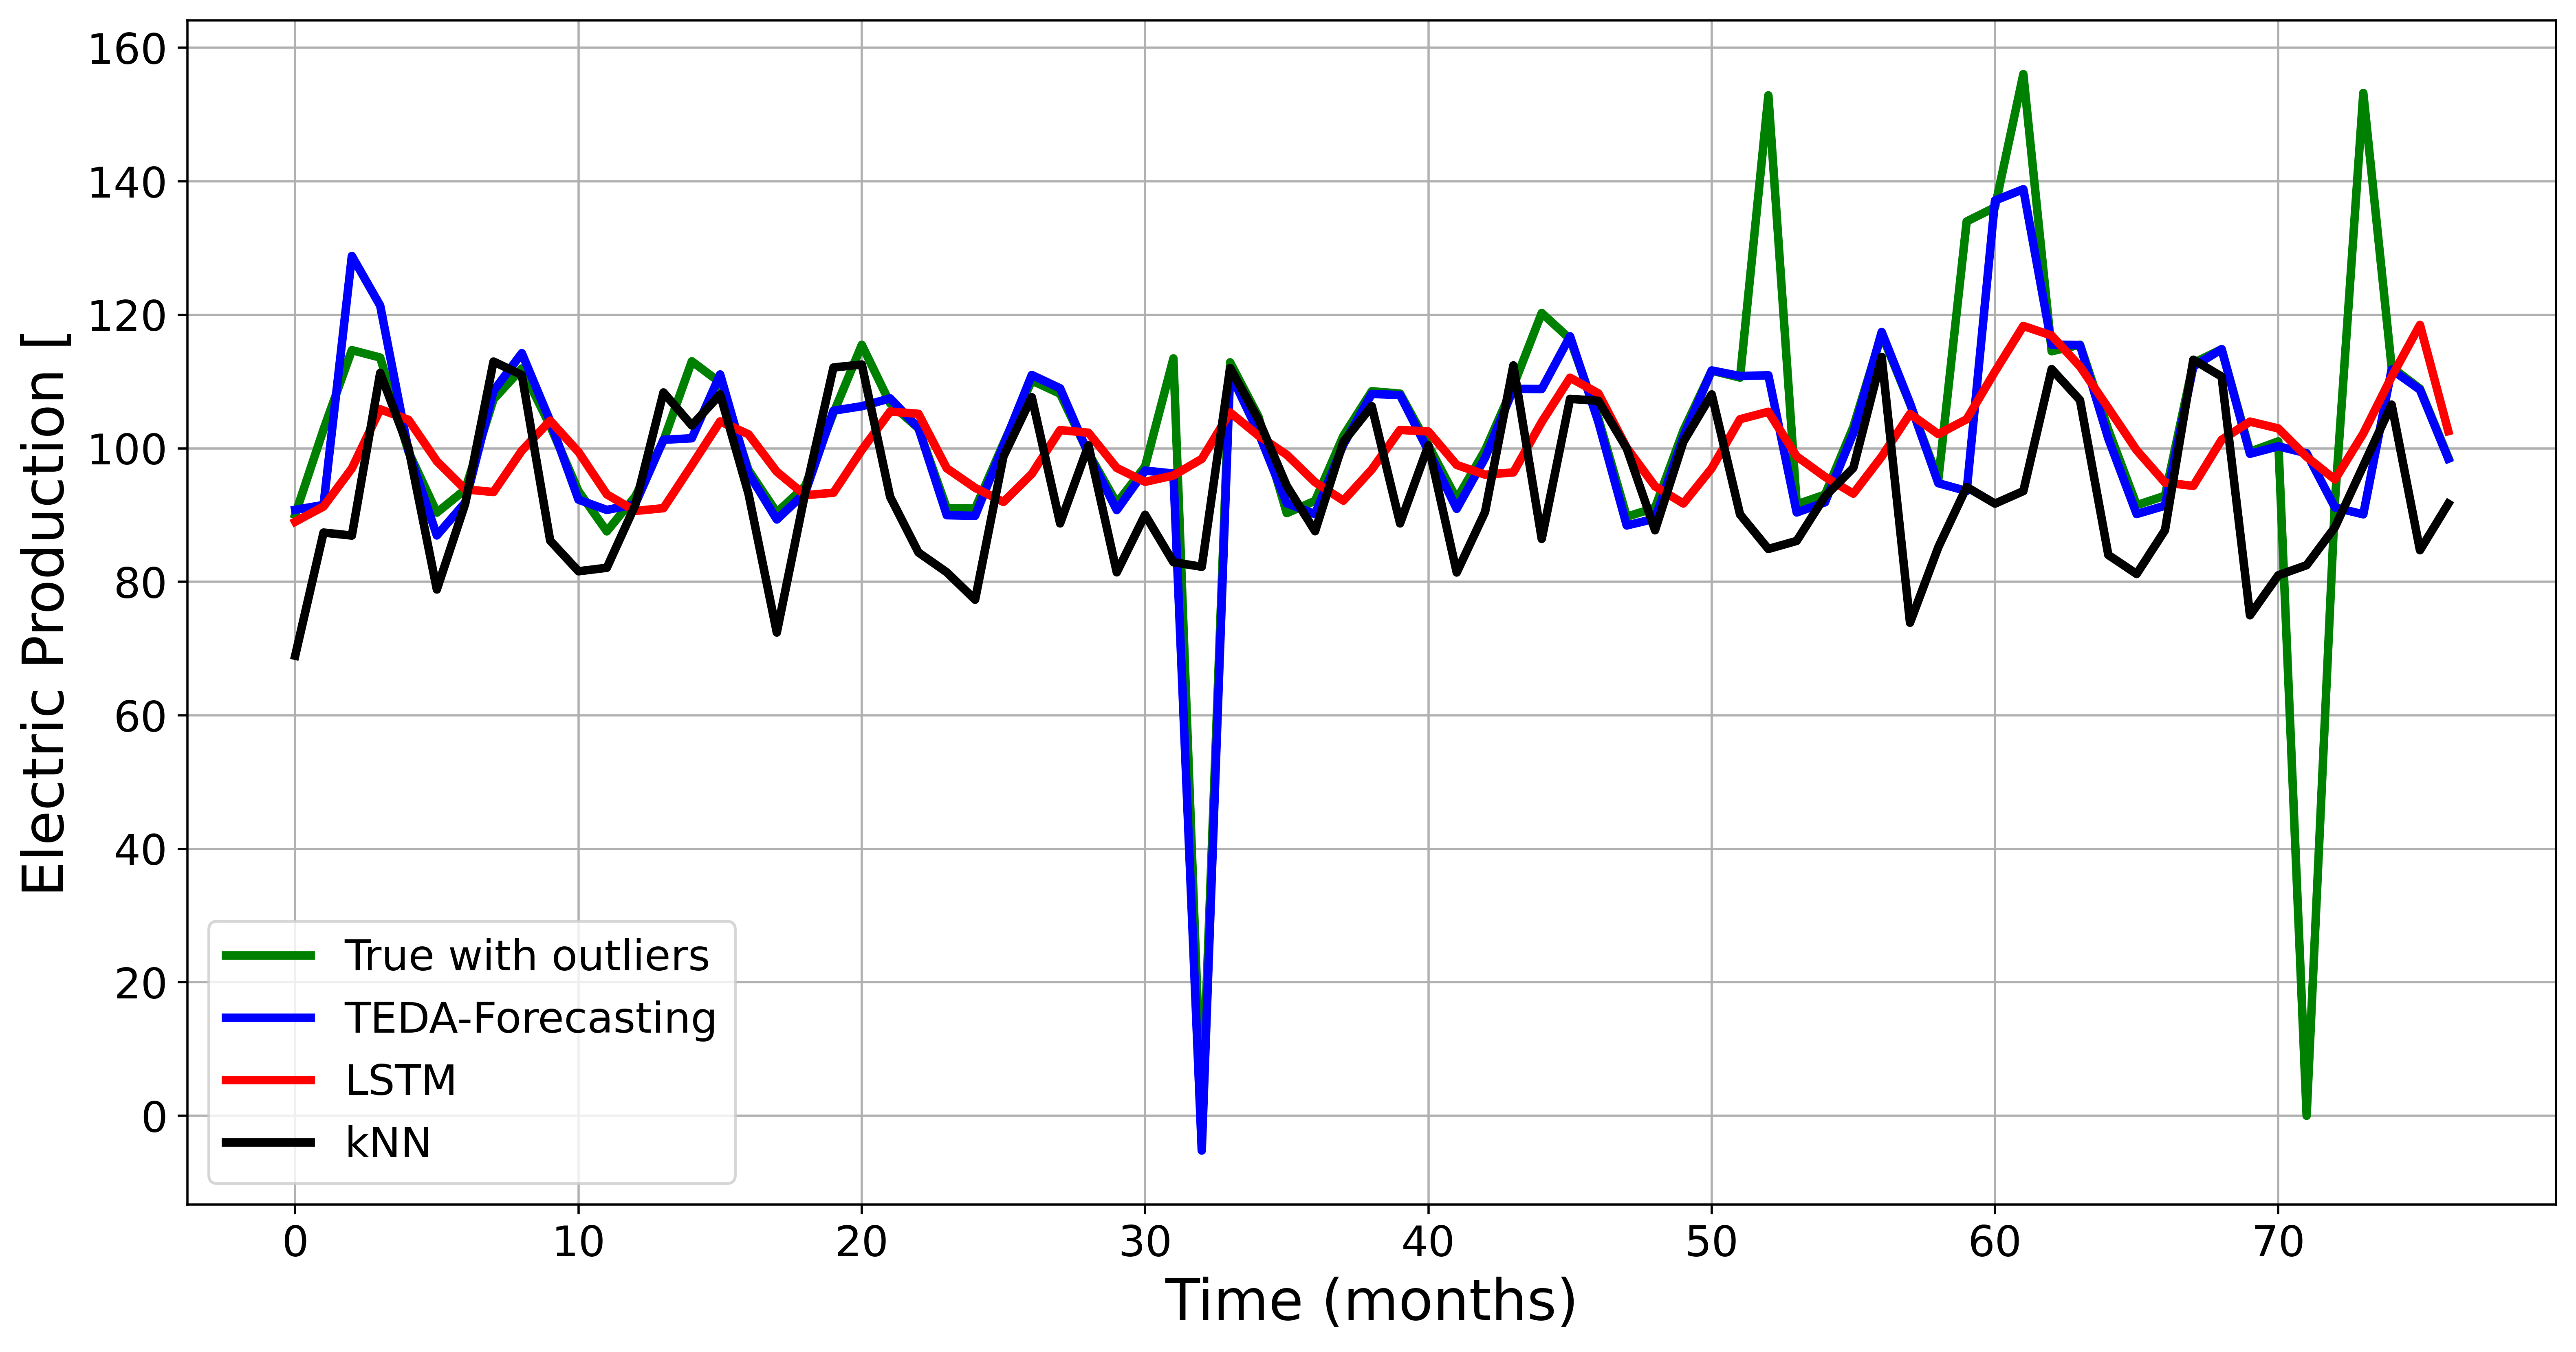

In [26]:
plt.figure(figsize=(15,7.7), dpi=500)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.xlabel("Time (months)", fontsize=20)
plt.ylabel("Electric Production [", fontsize=20)
plt.plot(y_test[0:-1, 0], 'g', label='True with outliers', linewidth=3)
plt.plot(df_Y_v.iloc[1:, 0].values, 'b', label='TEDA-Forecasting', linewidth=3)
plt.plot(np.array(Y_LSTM)[1:, 0], 'r', label='LSTM', linewidth=3)
plt.plot(np.array(Y_KNN)[1:, 0], 'k', label='kNN', linewidth=3)
plt.legend(fontsize=15)

plt.savefig('Comparison_teda_forecasting.eps', format='eps', bbox_inches='tight')


In [27]:
figure = make_subplots(specs=[[{"secondary_y": True}]])

figure.update_layout(
    title="Dataset with outliers"
)

figure.add_trace(
    go.Scatter(y=y_test[0:-1, 0], name='True With Outliers'),
    secondary_y=False
)

figure.add_trace(
    go.Scatter(y=df_Y_v.iloc[1:, 0].values, name='TEDA-Forecasting'),
    secondary_y=False
)

figure.add_trace(
    go.Scatter(y=np.array(Y_LSTM)[1:, 0], name='LSTM'),
    secondary_y=False
)

figure.add_trace(
    go.Scatter(y=np.array(Y_KNN)[1:, 0], name='kNN'),
    secondary_y=False
)



figure.update_xaxes(title='Time (months)')
figure.update_yaxes(title='Eletric Production', secondary_y=False)
figure.show()

## Ratios

In [28]:
RMSE_full_tf

[[15.571151992148236,
  26.477385911121896,
  30.343904498992522,
  32.071616907819596]]

In [29]:
RMSE_full_lstm

[[20.534041211176945,
  22.86211396997461,
  23.775955526925067,
  23.174441861825567]]

In [30]:
RMSE_full_knn

[[22.693283202491422,
  23.034928633713513,
  23.776714795825146,
  23.526090751066945]]

In [31]:
ratio_RMSE_TF_LSTM = []
for i in range(0, forecasting):
    ratio_RMSE_TF_LSTM.append(RMSE_full_tf[0][i]/RMSE_full_lstm[0][i])
ratio_RMSE_TF_LSTM

[0.7583091819097283, 1.1581337555177666, 1.276243323412579, 1.3839218695769337]

In [32]:
ratio_RMSE_TF_KNN = []
for i in range(0, forecasting):
    ratio_RMSE_TF_KNN.append(RMSE_full_tf[0][i]/RMSE_full_knn[0][i])
ratio_RMSE_TF_KNN

[0.6861568620638696,
 1.1494451027892514,
 1.2762025687552294,
 1.3632361299280076]

In [33]:
MAE_full_tf

[[5.308627700437807, 15.92421666944663, 21.8926823722951, 23.42071404237972]]

In [34]:
MAE_full_lstm

[[11.500717943543275,
  15.139233188222912,
  16.111734788295202,
  15.25239044744318]]

In [35]:
MAE_full_knn

[[13.929739220779222,
  14.485607792207796,
  14.10457584415585,
  13.985110779220777]]

In [36]:
ratio_MAE_TF_LSTM = []
for i in range(0, forecasting):
    ratio_MAE_TF_LSTM.append(MAE_full_tf[0][i]/MAE_full_lstm[0][i])
ratio_MAE_TF_LSTM

[0.4615909829714738, 1.0518509406298313, 1.3588035466050261, 1.535543829872637]

In [37]:
ratio_MAE_TF_KNN = []
for i in range(0, forecasting):
    ratio_MAE_TF_KNN.append(MAE_full_tf[0][i]/MAE_full_knn[0][i])
ratio_MAE_TF_KNN

[0.3811002931425191, 1.099312980019568, 1.552168786512372, 1.674689204262755]

# 5. References

 [[1]](https://www.mdpi.com/1424-8220/22/10/3838) **Andrade, P.**; Silva, I.; Silva, M.; Flores, T.; Cassiano, J.; Costa, D.G. *A TinyML Soft-Sensor Approach for Low-Cost Detection and Monitoring of Vehicular Emissions*. SENSORS 2022, 22, 3838.  ![GitHub](https://img.shields.io/badge/DOI-10.3390%2Fs22103838-green)


[[2]](https://dl.acm.org/journal/tecs) **Andrade, P.**; Silva, I.; Silva, M.; Flores, T.; Costa, D.G. Soares, E.; _Online Processing of Vehicular Data on the Edge Through an Unsupervised TinyML Regression Technique_. ACM TECS 2023. ![GitHub](https://img.shields.io/badge/DOI-10.1145%2Fs3591356-green)